# **MPA-MLF - Final project**

Classification of room occupancy

# Task description
The project’s task is to classify the number of persons present in the room from 60 GHz signal transmission. The dataset consists of snapshots of signal in delay-Doppler domain that represent the reflections from the targets (humans) at some distance from the receiver moving with some velocity. To explain: the faster the person moves, the higher Doppler frequency shifts it generates. The farther from the receiver the person is, the higher delay it generates. Examples of delay-Doppler snapshot are shown on Fig. 1 for one, two, and three persons in the room. Note that these examples represent almost ideal records, while the real records may be distorted by noise, reflections, missed targets etc.

In all these three cases, each file represents one two-dimensional snapshot in delay-Doppler domain.You can choose whatever format you prefer for your work.


The goal is to classify the number of persons present in the room from a given snapshot. Thus, one of the following three classes may be valid:
* One person in the room
* Two persons in the room
* Three persons in the room.

If you do not have satisfactory performance of the classifier, you can simplify classification task to:

* One person in the room
* More than one person in the room.

Your task is to build a model for classification on the dataset described above. We do not prescribe the type of ML model. You can use any architecture we discussed during the semester. Try to achieve the highest testing accuracy possible. Tune your model’s performance using any techniques we discussed, like Data augmentation, Regularization, Batch normalization etc. You can use any Hyperparameter tunning algorithm to find the best hyperparameters and the model structure (but it is not required).

# **Task**

PNG images will be used for training and testing the model. Optuna library for hyperparameter tuning will be used and best performing model fine-tuned separately.

# Preparation

Installing Optuna for hyperparmeter optimization, importing libraries and connecting Google Drive, where training and testing data is accesible.

In [ ]:
# Install Optuna for hyperparameter optimization

!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Necessary imports

import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
import re
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AlphaDropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import optuna
from optuna.integration import KerasPruningCallback
from optuna.integration import TFKerasPruningCallback
import zipfile
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [ ]:
# Connect Google Drive

from google.colab import drive
drive.mount('/content/drive')

x_train_path = "/content/drive/MyDrive/mlf_project_files/x_train"
y_train_path = "/content/drive/MyDrive/mlf_project_files/y_train.csv"

Mounted at /content/drive


# Data loading and preprocessing

Function *load_train_data* will load x_train data (images) and y_train data (CSV file). It reduces the image size to 50x44 px, which is the actual amount of pixels/blocks of the Doppler radar output, and normalizes RGB values. CSV file is one-hot encoded. White border around the images is removed by cropping.

In [ ]:
# Function for loading test data an preprocessing

def load_train_data(images_path, csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Load images and preprocess
    images = []
    
    for _, row in df.iterrows():
        file = os.path.join(images_path, f"img_{row['id']}.png")
        try:
            # Open the image
            image = Image.open(file)

            # Convert to RGB
            image = image.convert('RGB')

            # Crop the image by 2 pixels from each side, which removes white border
            width, height = image.size
            left, upper, right, lower = 2, 2, width - 2, height - 2
            image = image.crop((left, upper, right, lower))

            # Resize to the actual amount of pixels
            image = image.resize((50, 44))

            # Normalize pixel values
            image = np.array(image).astype('float32') / 255.0

            images.append(image)

        except IOError as e:
            print(f"Error reading image {file}: {e}")
            continue

    images = np.array(images)
    labels = pd.get_dummies(df['target'])

    return images, labels


Load and preprocess the data (only if 'x_train_data.npy' and 'y_train_data.npy' are not available):

In [ ]:
x_train, y_train = load_train_data(x_train_path, y_train_path)

Save training data as NPY files for faster loading without downloading from drive and preprocessing:

In [ ]:
np.save('x_train_data.npy', x_train)
np.save('y_train_data.npy', y_train)

Load previously saved NPY files:

In [ ]:
x_train = np.load('/content/drive/MyDrive/mlf_project_files/x_train_data.npy')
y_train = np.load('/content/drive/MyDrive/mlf_project_files/y_train_data.npy')

Check number of samples:

In [ ]:
print(f"Number of samples in x_train: {len(x_train)}")
print(f"Number of samples in y_train: {len(y_train)}")

if len(x_train) == len(y_train):
  print("Training data loaded correctly.")

Number of samples in x_train: 8279
Number of samples in y_train: 8279
Training data loaded correctly.


Save first training image as PNG to download and visually check correct preprocessing:


In [ ]:
img_0_test = x_train[0]

denormalized_image = (img_0_test * 255).astype(np.uint8)

img_0_test = Image.fromarray(denormalized_image)

img_0_test.save('img_0_test.png')

Show first 3 images and corresponding number of people:

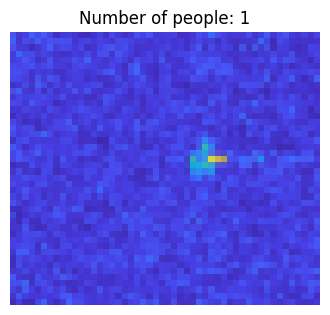

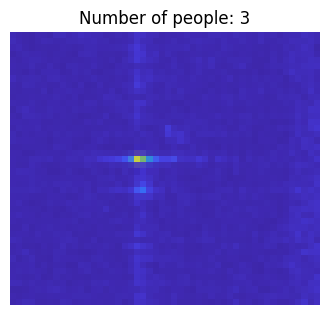

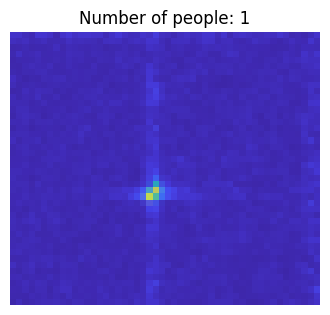

In [ ]:
for i in range(3):
  plt.figure(figsize=(4, 4))
  plt.imshow(x_train[i], cmap='gray')
  plt.title(f"Number of people: {np.argmax(y_train.iloc[i].values) + 1}")
  plt.axis("off")
  plt.show()

# Model creation for hyperparameter optimization

Function *create_model* will create a model for each trial of hyperparameter tuning. It creates a variable number of convolutional layers and fixed number of MaxPooling2D, Dense, Flatten and Dropout layers. Variable layer parameters are suggested by suggest methods of each trial. Output layer has 3 neurons to match one-hot encoding of y_train dataset.

In [ ]:
def create_model(trial):
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 2)
    model = Sequential()

    for i in range(num_conv_layers):
        filters = trial.suggest_int(f"filters_layer_{i}", 16, 64, step=16)
        kernel_size = trial.suggest_int(f"kernel_size_layer_{i}", 3, 5, step=2)
        activation = trial.suggest_categorical(f"activation_layer_{i}", ["relu", "elu", "selu"])

        if i == 0:
            model.add(Conv2D(filters, kernel_size, activation=activation, input_shape=(44, 50, 3)))
        else:
            model.add(Conv2D(filters, kernel_size, activation=activation))


    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="selu"))
    model.add(AlphaDropout(0.5))
    model.add(Dense(3, activation="softmax"))

    return model


# Objective function

The *objective* function sets Adam optimizer, compiles the model and trains the model based on suggested hyperparameters in predefined range. Then it returns the model with lowest validation loss. Validation split is set to 20%. It takes x_train and y_train as inputs, trial input is set automatically. Pruning and early stopping are set to minimize processing time and output the best result of each trial.

In [ ]:
def objective(x_train, y_train, trial):
    # Create the model, hyperparameters defined by trial input
    model = create_model(trial)

    # Compile the model
    optimizer = Adam(learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True))
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Set early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

    # Train the model, batch size varies from 16 to 128
    model_checkpoint = ModelCheckpoint("model_check.h5", monitor="val_accuracy", save_best_only=True, mode="max")
    keras_pruning = TFKerasPruningCallback(trial, "val_accuracy")

    history = model.fit(
        x_train,
        y_train,
        batch_size=trial.suggest_int("batch_size", 16, 80, step=16),
        epochs=100,
        callbacks=[model_checkpoint, keras_pruning, early_stopping],
        validation_split=0.2,
        verbose=0
    )

    # Return the minimum validation loss achieved during training
    return min(history.history["val_accuracy"])


# Hyperparameter optimization

The following code runs through hyperparameters to find the best combination, that produces a model with maximal validation acccuracy. It utilizes the above *objective* function, which utilizes the *create_model* function. Pruning will be initiated after at least 5 non-satisfying epochs. Early stopping ensures the best epoch of each successful trial will be saved.

In [ ]:
# Run the hyperparameter study, pruning does not occur in the first 2 epochs for each trial
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=2))
study.optimize(lambda trial: objective(x_train, y_train, trial), n_trials=40)

# Find the best trial and show its parameters
best_trial = study.best_trial
print(f"Best trial: {best_trial.number}")
print(f"Best value (val_accuracy): {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

# Load the best model
top_model = create_model(optuna.trial.FixedTrial(best_trial.params))

Show the best model sumary:

In [ ]:
top_model.summary()

Save the model for later use:

In [ ]:
top_model.save('top_model.h5')

Import a previously saved model (no need for time consuming training)

In [ ]:
from keras.models import load_model

top_model = load_model('top_model.h5')

# Model tuning without hyperparameter optimization

Tuning the best performing model by chanching hyperparameters. Model below is the best performing model from hyperparameter tuning. Batch size in *fit* function was changed from 128 to 160 for the final result.

In [ ]:
model2 = Sequential()

model2.add(Conv2D(48, 3, activation="elu", input_shape=(44, 50, 3)))

model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(512, activation="selu"))
model2.add(AlphaDropout(0.5))
model2.add(Dense(3, activation="softmax"))

model2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 42, 48, 48)        1344      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 24, 48)       0         
 2D)                                                             
                                                                 
 flatten_45 (Flatten)        (None, 24192)             0         
                                                                 
 dense_116 (Dense)           (None, 512)               12386816  
                                                                 
 alpha_dropout_28 (AlphaDrop  (None, 512)              0         
 out)                                                            
                                                                 
 dense_117 (Dense)           (None, 3)               

Show model diagram:

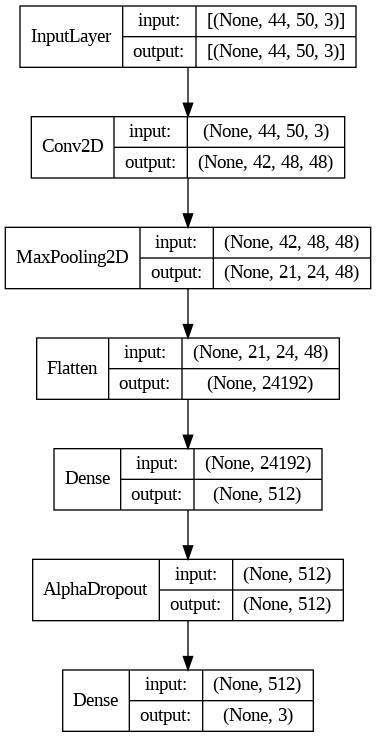

In [ ]:
plot_model(model2, to_file='model_diagram.png', show_shapes=True, show_layer_names=False)

In [ ]:
optimizer = Adam(learning_rate=0.005)
model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
history = model2.fit(
    x_train,
    y_train,
    batch_size=160,
    epochs=100,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
42/42 [==============================] - 41s 989ms/step - loss: 0.0615 - accuracy: 0.9786 - val_loss: 0.1800 - val_accuracy: 0.9571
Epoch 2/100
42/42 [==============================] - 37s 892ms/step - loss: 0.0596 - accuracy: 0.9807 - val_loss: 0.1785 - val_accuracy: 0.9644
Epoch 3/100
42/42 [==============================] - 40s 948ms/step - loss: 0.0734 - accuracy: 0.9733 - val_loss: 0.1357 - val_accuracy: 0.9626
Epoch 4/100
42/42 [==============================] - 37s 875ms/step - loss: 0.0552 - accuracy: 0.9817 - val_loss: 0.1354 - val_accuracy: 0.9698
Epoch 5/100
42/42 [==============================] - 40s 967ms/step - loss: 0.0549 - accuracy: 0.9820 - val_loss: 0.1016 - val_accuracy: 0.9728
Epoch 6/100
42/42 [==============================] - 38s 899ms/step - loss: 0.0445 - accuracy: 0.9840 - val_loss: 0.1362 - val_accuracy: 0.9698
Epoch 7/100
42/42 [==============================] - 39s 915ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.1763 - val_accuracy:

In [ ]:
model2.save('top_model_97.h5')

# Model testing

Testing dataset will be downloaded and used as input for trained model. The model will produce y_test data, which will be uploaded and verified on Kaggle. 

First, *load_test_data* function will download x_test dataset from Google Drive and preprocess it. Preprocessing consists of sorting in correct order by the integer in image filename and filtering out unwated files. Those are non-png files and duplicates. Duplicates are identified by their use of parenteses "()" in the filename.

In [ ]:
def load_test_data(images_path):
    
    images = []

    # Load PNG images
    all_files = os.listdir(images_path)
    png_files = [file for file in all_files if file.endswith('.png')]

    # Filter out duplicates
    non_duplicate_files = [file for file in png_files if not re.search(r'\(\d+\)', file)]

    # Sort images by number in filename
    file_names = sorted(non_duplicate_files, key=lambda x: int(re.findall(r'\d+', x)[0]))


    for file_name in file_names:
        file = os.path.join(images_path, file_name)
        try:
            # Open the image
            image = Image.open(file)

            # Convert to RGB
            image = image.convert('RGB')

            # Crop the image by 2 pixels from each side, which removes white border
            width, height = image.size
            left, upper, right, lower = 2, 2, width - 2, height - 2
            image = image.crop((left, upper, right, lower))

            # Resize to actual amount of pixels
            image = image.resize((50, 44))

            # Normalize pixel values
            image = np.array(image).astype('float32') / 255.0

            images.append(image)

        except IOError as e:
            print(f"Error reading image {file}: {e}")
            continue

    images = np.array(images)
    return images


Only run if 'x_test_data.npy' is not available:

In [ ]:
x_test_path = "/content/drive/MyDrive/mlf_project_files/x_test"
x_test = load_test_data(x_test_path)

In [ ]:
np.save('x_test_data.npy', x_test)

In [ ]:
x_test = np.load('/content/drive/MyDrive/mlf_project_files/x_test_data.npy')

Download first image and visually verify correct preprocessing of test data:

In [ ]:
img_0_test = x_test[0]

denormalized_image = (img_0_test * 255).astype(np.uint8)

img_0_test = Image.fromarray(denormalized_image)

img_0_test.save('img_0_test2.png')

Generate output predictions y_test from x_test and decode one-hot code:

In [ ]:
y_test_pred = model2.predict(x_test)

y_test_labels = np.argmax(y_test_pred, axis=1)+1

111/111 [==============================] - 5s 41ms/step


Show result of first 3 test images:

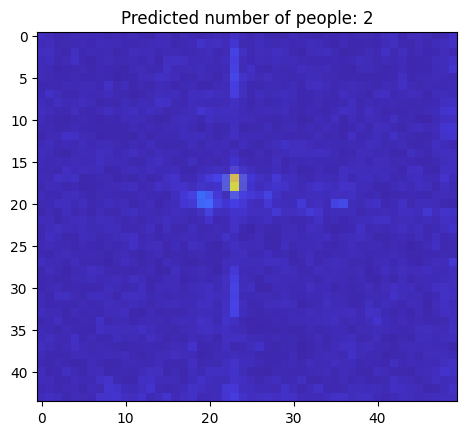

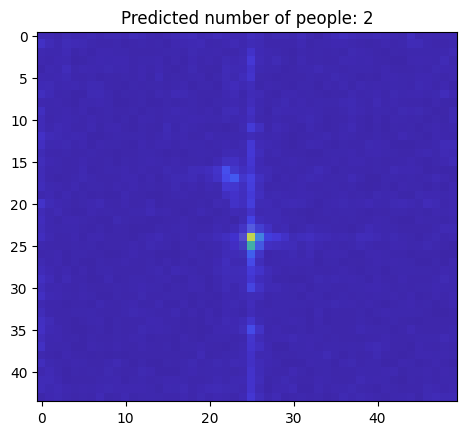

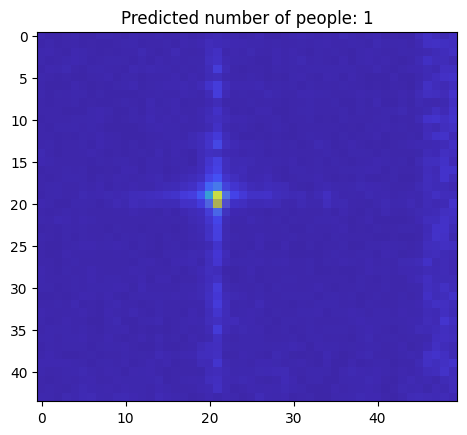

In [ ]:
for i in range(3):
    plt.imshow(x_test[i])
    plt.title(f"Predicted number of people: {y_test_labels[i]}")
    plt.show()

Create a CSV file in the right format, so it can be uploaded to Keggle:

In [ ]:
y_test = pd.DataFrame({'id': range(len(y_test_labels)), 'target': y_test_labels})

y_test.to_csv('y_test.csv', index=False)

The end.